# Using Time Series Data to Predict Taxi Orders by the Hour

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [7]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# import timeseries tools
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf


# model building tools
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# models to train
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from lightgbm import LGBMRegressor

In [8]:
td = pd.read_csv('taxi.csv')
display(td.tail())
print('\n Data Types:')
print(td.dtypes)
print('\n Data Info:')
print(td.info())

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53



 Data Types:
datetime      object
num_orders     int64
dtype: object

 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


This data comes in the form of 10 minute intervals starting at 1 March 2018 at midnight. It continues until 11:50PM on 31 August 2018.

In [9]:
# Read the csv file to "data" and parse the dates
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

# Sort the index based on the datetime feature
data.sort_index(inplace=True)

# resample based on the hour and add together all of the orders
data = data.resample('1H').sum()

# observe the data
display(data.head())
data.info()

C:\Users\markl\AppData\Local\Temp\ipykernel_25716\4045482656.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [10]:
# Calculate the Mean, Median, and Standard Deviation
mean = data['num_orders'].mean()
median = data['num_orders'].median()
std = data['num_orders'].std()

print(f'Average rides per hour: {mean:.2f}')
print(f'Median rides per hour: {median:.2f}')
print(f'Standard Deviation per hour: {std:.2f}')

Average rides per hour: 84.42
Median rides per hour: 78.00
Standard Deviation per hour: 45.02


<Axes: xlabel='datetime'>

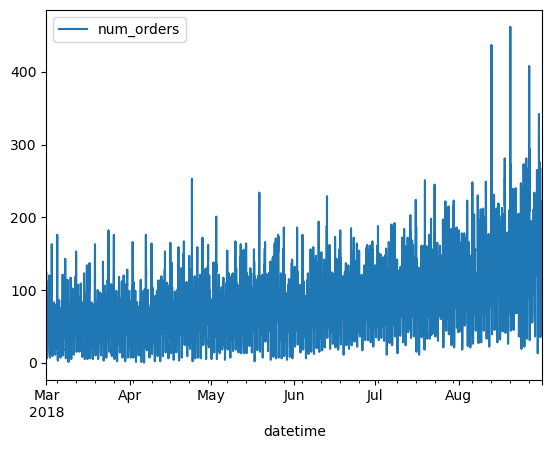

In [11]:
# plot the data in its original form visualize it
data.plot()

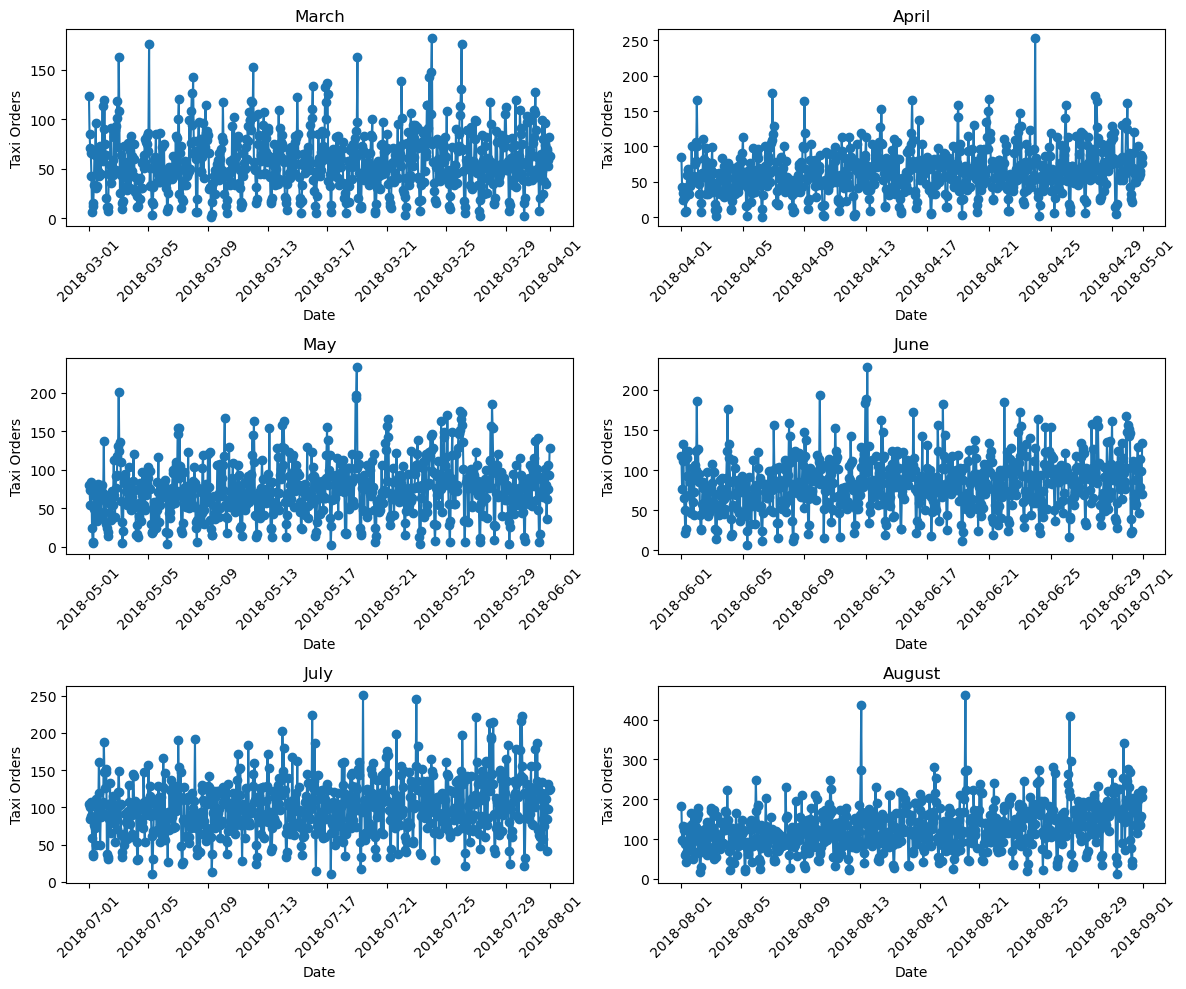

In [12]:
# show the data by month to look for trends on a monthly timeframe
march = data['2018-03': '2018-03']
april = data['2018-04': '2018-04']
may = data['2018-05': '2018-05']
june = data['2018-06': '2018-06']
july = data['2018-07': '2018-07']
august = data['2018-08': '2018-08']
months = [march, april, may, june, july, august]

month_names = ["March", "April", "May", "June", "July", "August"]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Plot each month's data
for i, month in enumerate(months):
    axes[i].plot(month.index, month['num_orders'], marker='o', linestyle='-')
    axes[i].set_title(month_names[i])
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Taxi Orders")
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [13]:
months = {
    'March': march,
    'April': april,
    'May': may,
    'June': june,
    'July': july,
    'August': august
}

for month_name, rides in months.items():
    print(f'In {month_name}, Sweet Lift provided {len(rides)} rides.')

In March, Sweet Lift provided 744 rides.
In April, Sweet Lift provided 720 rides.
In May, Sweet Lift provided 744 rides.
In June, Sweet Lift provided 720 rides.
In July, Sweet Lift provided 744 rides.
In August, Sweet Lift provided 744 rides.


### Initial data observations ###
There does not appear to be a strong trend that would suggest seasonality in the data. Each month has nearly the same amount of rides with June and April having 3% less rides than the other months.

### Test Stationarity of the Data ###

In [14]:
def test_stationarity(timeseries):
    # calculated rolling mean and standard deviation
    rolling_mean = timeseries.rolling(168).mean()
    rolling_std = timeseries.rolling(168).std()
    
    # plot rolling statistics
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='gold', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

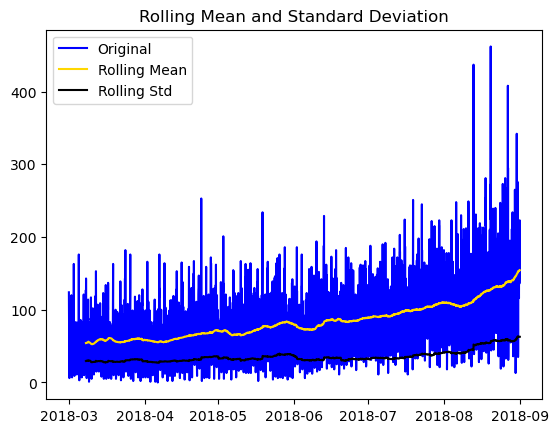

In [15]:
test_stationarity(data)

#### Preliminary observation and interpretation ####
We can see in the above plot that the mean grows over time and the rolling std is also changing. This could suggest that we're dealing with a non-stationary data set. It is not a drastic change, and since each month had nearly the same amount of rides, I'm going to do a closer look at the stationariy by using the adfuller method.

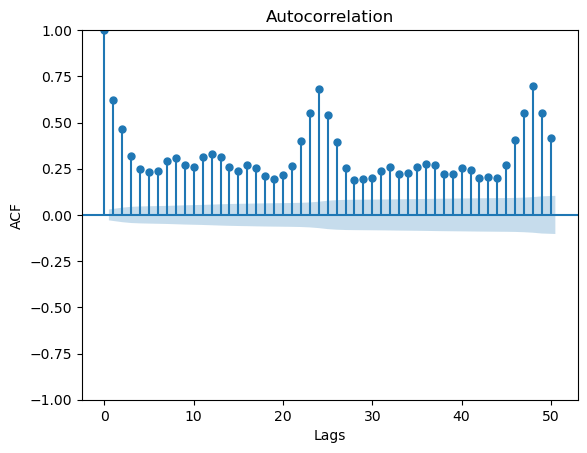

In [16]:
lags_to_check = 50
acf = plot_acf(data, lags=lags_to_check)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

In [17]:
# run the adfuller test to check for stationarity
df_stationarityTest = adfuller(data, autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  0.02894005140261296


#### Interpretation after using adfuller ####
with a p value of .03 like this, we can predict that this data would be considered stationary. So, we can use the ARMA as our predictive model for this data. The data has the appearance of being non-stationary in the last month of data collection, but because the pvalue is below the .05 threshold, we're going to treat this data as stationary in our model development

#### Look at what using Differencing and Decomposition might do for the data

In [18]:
# Use differencing to show what the data could look like if to enhance the stationarity
data_diff = data - data.shift()

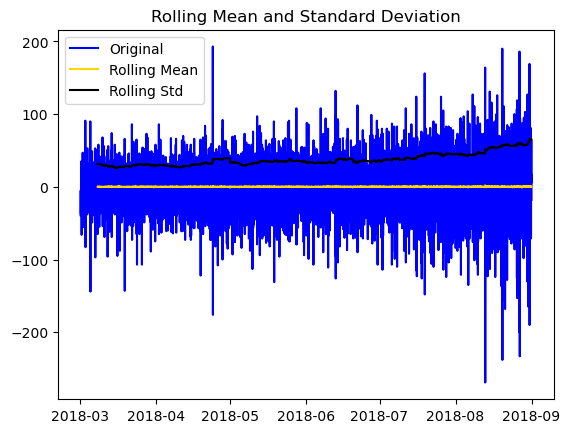

In [19]:
# show the stationarity of the differenced data
data_diff.dropna(inplace=True)
test_stationarity(data_diff)

In [20]:
display(data_diff.head())

,num_orders
datetime,
2018-03-01 01:00:00,-39.0
2018-03-01 02:00:00,-14.0
2018-03-01 03:00:00,-5.0
2018-03-01 04:00:00,-23.0
2018-03-01 05:00:00,-37.0


In [21]:
# run the adfuller test to check for stationarity on the differenced data
df_stationarityTest = adfuller(data_diff, autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  1.0958776746516691e-28


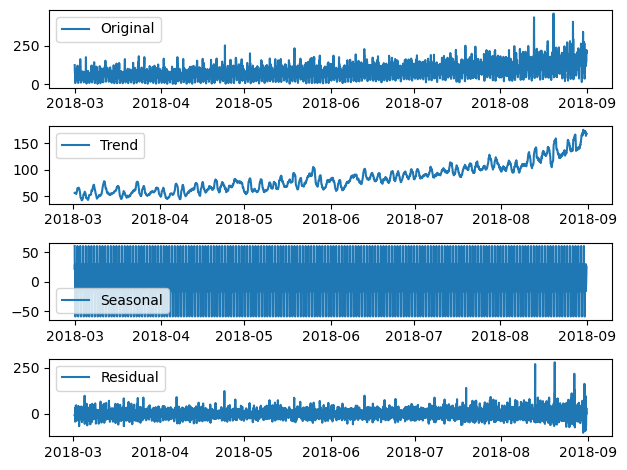

In [22]:
# run the seasonal decomposition function on our data
decomposed = seasonal_decompose(data)

# create variables of the trend, seasonal, and residual data
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

# plot the original data
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')

# plot the trend
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

#plot the seasonal 
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

# plot the residual
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')

plt.tight_layout()


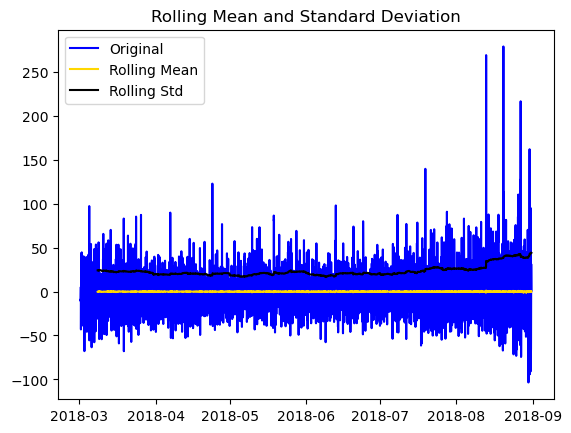

In [23]:
# show how the residual data does with stationarity
data_decompose = residual
data_decompose.dropna(inplace=True)
test_stationarity(data_decompose)

In [24]:
# run the adfuller test to check for stationarity on the decomposed data
df_stationarityTest = adfuller(data_decompose, autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  0.0


#### Stationarity Conclusions ####
Using the decompose method and the differencing method allowed for making the data even more stationary for analysis purposes. These adjusted data sets will allow for better predictions using a linear regression model.

## Analysis

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())
    
    return data

In [26]:
ts = make_features(data_diff, 25, 25)

In [27]:
display(ts.head(10))

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 01:00:00,-39.0,2018,3,1,3,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14.0,2018,3,1,3,2,-39.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5.0,2018,3,1,3,3,-14.0,-39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23.0,2018,3,1,3,4,-5.0,-14.0,-39.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,-37.0,2018,3,1,3,5,-23.0,-5.0,-14.0,-39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,6.0,2018,3,1,3,6,-37.0,-23.0,-5.0,-14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,3.0,2018,3,1,3,7,6.0,-37.0,-23.0,-5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,19.0,2018,3,1,3,8,3.0,6.0,-37.0,-23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 09:00:00,35.0,2018,3,1,3,9,19.0,3.0,6.0,-37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Training

In [28]:
train, test = train_test_split(ts, shuffle=False, test_size=.1)
train= train.dropna()
test = test.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [29]:
# use one hot encoding for the days, days of the week and month columns
features_train = pd.get_dummies(features_train, columns=['month', 'day', 'dayofweek', 'hour'], drop_first=True)
features_test = pd.get_dummies(features_test, columns=['month', 'day', 'dayofweek', 'hour'], drop_first=True)

features_train, features_test = features_train.align(features_test, join='left', axis=1)
features_test = features_test.fillna(0)

## Testing

In [30]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, **hyperparameters):
    # Set the hyperparameters of the model
    model.set_params(**hyperparameters)
    
    # fit the model
    model.fit(X_train, y_train)
     
    # make predictions
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    # Evaluate the model
    rmse_train = np.sqrt(mean_squared_error(y_train, prediction_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, prediction_test))
    
    return rmse_train, rmse_test

In [31]:
# Initialize model
lr_model = LinearRegression()

# Define hyperparameters
hyperparams = {}

# Train and evaluate
rmse_train, rmse_test = train_evaluate_model(lr_model, features_train, target_train, features_test, target_test, **hyperparams)

print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")

Train RMSE: 22.90
Test RMSE: 41.87


#### Linear Regression Results ####
The RMSE for our initial Linear Regression Model is already below the 48 threshhold in the test set. This could be a sufficient model for prediction. I will continue by checking the ARMA and ARIMA models as well to see how they interact with this data.

#### LGBM Model ####

In [32]:
# Initialize LGBMRegressor
lgbm = LGBMRegressor()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameter grid
param_grid = {
    'num_leaves': [10, 15],
    'max_depth': [10, 15],
    'learning_rate': [0.2, 0.17],
    'n_estimators': [60, 50],
}

# GridSearch with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=tscv,  # Use TimeSeriesSplit
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Correct order: features first, then target
grid_search.fit(features_train, target_train)

# Best parameters and RMSE
print("Best parameters:", grid_search.best_params_)
print("Best RMSE (CV):", (-grid_search.best_score_)**0.5)

# Final test set evaluation
best_model = grid_search.best_estimator_

# Correct usage of predict()
y_pred = best_model.predict(features_test)

# Correct MSE calculation
test_rmse = mean_squared_error(target_test, y_pred, squared=False)
print(f'Test Set RMSE: {test_rmse}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4969
[LightGBM] [Info] Number of data points in the train set: 3948, number of used features: 90
[LightGBM] [Info] Start training from score -0.000253
Best parameters: {'learning_rate': 0.17, 'max_depth': 10, 'n_estimators': 60, 'num_leaves': 15}
Best RMSE (CV): 27.760765835625506
Test Set RMSE: 44.83738114187527


c:\Users\markl\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [33]:
lgbm = LGBMRegressor()
hyperparameters = {'n_estimators': 60, 'max_depth': 10, 'num_leaves': 15, 'learning_rate': 0.17}
rmse_train, rmse_test = train_evaluate_model(lgbm, features_train, target_train, features_test, target_test, **hyperparameters)
print(f'Training RMSE: {rmse_train:.2f}')
print(f"Test RMSE:{rmse_test:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4969
[LightGBM] [Info] Number of data points in the train set: 3948, number of used features: 90
[LightGBM] [Info] Start training from score -0.000253
Training RMSE: 18.35
Test RMSE:44.84


#### LGBM Results ####
This model also produced an RMSE below the 48 threshold, but the Linear Regression Model still is a more effective model for our purspose with an RMSE lower by 3 points.

#### ARMA Model ####

Since the adfuller method showed that this data is stationary, I'm going to apply the ARMA model to see how it does at predicting the amount of orders in the test set. 

In [34]:
# split the data for the ARMA model
train_ar, test_ar = train_test_split(data, shuffle=False, test_size=.1)
train_ar.dropna(inplace=True)
test_ar.dropna(inplace=True)


mod = ar_select_order(endog=train_ar, maxlag=30)
ar_order = mod.ar_lags

ar_model = AutoReg(train_ar, lags=ar_order)
ar_model = ar_model.fit()

start_value = len(train_ar)
end_value = len(train_ar) + len(test_ar) - 1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)

ar_rmse_test = np.sqrt(mean_squared_error(test_ar, ar_pred))
print('ARMA Model Test RMSE:', ar_rmse_test)

ARMA Model Test RMSE: 74.34342740454213


#### ARMA Results ####
The RMSE results in this model did not meet the 48 threshold, so it appears that it would be better to apply the Linear Regression model above.

#### ARIMA Model ####

Since the charts above showed a possibility of non-stationary data, I think it would stil be useful to apply the ARIMA model to see if it can produce a more effect RMSE in its predictions.

In [35]:
# Find the optimal ARIMA model
model = auto_arima(train_ar, trace=True, supress_warnings=True)

# get info about the model
parameters = model.get_params()
for key, value in parameters.items():
    print(f"{key}: {value}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39785.522, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39407.923, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39248.315, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39783.522, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39246.314, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39405.923, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.79 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 11.643 seconds
maxiter: 50
method: lbfgs
order: (0, 1, 1)
out_of_

In [36]:
# Set model orders
ar_order = 0
diff_order = 1
ma_order = 1
arima_full_order = (ar_order, diff_order, ma_order)

# Create and fit ARIMA model
arima_model = ARIMA(train_ar, order=arima_full_order)
arima_model = arima_model.fit()

# Generate predictions
start_index = len(train_ar)
end_index = len(train_ar) + len(test_ar) - 1 

arima_pred = arima_model.predict(start=start_index, end=end_index, dynamic=False)

# Compute RMSE
arima_rmse_test = np.sqrt(mean_squared_error(test_ar, arima_pred))
print('ARIMA Model Test RMSE:', arima_rmse_test)

ARIMA Model Test RMSE: 62.7680945627838


## Conclusion ##

Sweet Ride Taxi Company tasked me to be able to predict how many rides will be orderd in the next hour. They provided a timeseries dataset that spanned from March of 2018 through August of 2018. I checked the data for stationarity, trends, and seasonality. I found that while looking at the data in chart form it was slightly non-stationary. However when I applied the adfuller method, the p-value fell below the .05 threshold suggesting that the data was infact stationary.

When it came time to build predictive models however, the only models that were able to produce RMSE values below 48 (the target value given by Sweet Ride) were the ones that used the data that was corrected for stationarity. 

The Linear Regression model was able to produce an RMSE value on the test set of 41.86, the LGBM model also made it below the 48 threshold at 44.84. The ARMA model and ARIMA models were unable to meet the need for the RMSE to be below 48. And, while the ARIMA model(62.8) outperformed the ARMA (74.3) one, neither were good matches for this work.

This sugggests that the best model for Sweet Ride Taxi Company to use would be the Linear Regression predictive model. 